<a href="https://colab.research.google.com/github/KirtiShingala122/perg-based-disease-detection/blob/main/full_pipeline_pf_perg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Preprocessing + Feature Extraction + Dataset Loading
# ------------------------------
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, savgol_filter, welch
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.stats import entropy as scipy_entropy

# --- SKLEARN IMPORTS ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --- BOOSTING IMPORTS (try/except retained) ---
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except:
    LGB_AVAILABLE = False

try:
    from catboost import CatBoostClassifier
    CAT_AVAILABLE = True
except:
    CAT_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except:
    SHAP_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 2) User paths
CSV_BASE = "/content/drive/MyDrive/PERG_dataset/csv"
META_PATH = "/content/drive/MyDrive/PERG_dataset/csv/participants_info.csv"

# 3) 5-class label mapping (Maintained)
def categorize_5class(d):
    if pd.isna(d): return None
    ds = str(d).lower()
    if "normal" in ds: return 0
    retinal_kw = ["retinitis pigmentosa", "retinitis", "rp", "usher", "stargardt", "fundus flavimaculatus", "macular dystrophy", "maculopathy", "dystrophy", "vitelliform", "drusen", "cone-rod", "rod-cone", "achromatopsia", "photoreceptor", "retinoschisis", "bietti", "pseudovitelliform", "foveal hypoplasia", "dominant drusen", "sorsby"]
    if any(k in ds for k in retinal_kw): return 1
    optic_kw = ["optic", "atrophy", "neuropathy", "neuritis", "naion", "nonarteritic", "retrobulbar", "traumatic optic", "toxic optic", "ischemic optic", "optic nerve atrophy", "optic neuropathy", "infectious neuritis"]
    if any(k in ds for k in optic_kw): return 2
    infl_kw = ["inflammatory", "autoimmune", "birdshot", "uveitis", "chorioretinopathy", "infection", "cns infection", "sarcoidosis", "toxicity", "chloroquine", "retinal toxicity", "macula toxicity"]
    if any(k in ds for k in infl_kw): return 3
    return 4

CLASS_NAMES_5 = ["Normal", "Retinal Deg", "Optic Nerve", "Inflammatory/Systemic", "Others"]

# ------------------------------
# Signal preprocessing helpers (UPDATED)
# ------------------------------

# ---------------------------------------------------------
# FIX: increased bandpass upper cutoff to 100 Hz (transient PERG)
# ---------------------------------------------------------
def butter_bandpass_filter(signal, low=1, high=100, fs=1700, order=4):
    nyq = fs/2.0
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal)

# -------------------------------------------
# ADD: 50 Hz Notch Filter (to remove mains noise)
# -------------------------------------------
def notch_filter(signal, fs=1700, freq=50, Q=30):
    # simple bandstop around mains frequency
    w0 = freq / (fs/2)
    # create narrow bandstop; ensure bounds within (0,1)
    low = max(1e-6, w0 - w0 / Q)
    high = min(0.999999, w0 + w0 / Q)
    b, a = butter(2, [low, high], btype='bandstop')
    return filtfilt(b, a, signal)

def hampel_filter(signal, window_len=7, nsig=3):
    arr = np.asarray(signal, dtype=float)
    n = len(arr)
    out = arr.copy()
    k = window_len // 2
    for i in range(k, n-k):
        window = arr[i-k:i+k+1]
        med = np.median(window)
        mad = np.median(np.abs(window - med))
        if mad == 0: continue
        threshold = nsig * 1.4826 * mad
        if abs(arr[i] - med) > threshold:
            out[i] = med
    return out

# ---------------------------------------------------------
# FIX: remove Savitzky–Golay smoothing, remove internal z-scaling;
#       apply bandpass (up to 100Hz) + notch + hampel only
# ---------------------------------------------------------
def preprocess_signal(signal, fs=1700):
    s = np.asarray(signal, dtype=float)
    if s.size == 0 or len(s) < 21:
        return np.array([]) # Min length check

    s = np.nan_to_num(s, nan=0.0, posinf=0.0, neginf=0.0)

    # FIX: transient PERG needs frequencies up to 100 Hz
    s = butter_bandpass_filter(s, low=1, high=100, fs=fs, order=4)

    # FIX: remove mains 50Hz noise
    s = notch_filter(s, fs=fs, freq=50, Q=30)

    s = hampel_filter(s, window_len=7, nsig=3)



    return s

# ------------------------------
# Feature engineering (Improved Peak/Feature Extraction) — UPDATED
# ------------------------------
def band_energies(sig, fs=1700):
    # Update bands to cover up to 100 Hz (transient PERG useful up to ~100 Hz)
    f, Pxx = welch(sig, fs=fs, nperseg=min(512, len(sig)))
    bands = {
        'delta': [1, 4],
        'theta': [4, 8],
        'alpha': [8, 13],
        'beta': [13, 30],
        'gamma': [30, 100]  # FIX: extend gamma to 100 Hz
    }
    energies = {k: Pxx[(f >= v[0]) & (f < v[1])].sum() for k, v in bands.items()}
    total = sum(energies.values()) + 1e-9
    return {
        "b1": energies['delta']+energies['theta'], "b2": energies['alpha']+energies['beta'], "b3": energies['gamma'],
        "b1_norm": (energies['delta']+energies['theta'])/total,
        "b2_norm": (energies['alpha']+energies['beta'])/total,
        "b3_norm": energies['gamma']/total,
        "spectral_power_delta": energies['delta'],
        "spectral_power_theta": energies['theta'],
        "spectral_power_alpha": energies['alpha'],
        "spectral_power_beta": energies['beta'],
        "spectral_power_gamma": energies['gamma'],
    }

def robust_peaks(sig, fs=1700):
    L = len(sig)
    # FIX: adaptive/dynamic windows (slightly wider to account for latency shifts)
    p50_start = int(0.035 * fs)
    p50_end = min(int(0.075 * fs), L-1)
    n95_start = int(0.080 * fs)
    n95_end = min(int(0.130 * fs), L-1)

    p50_idx = 0
    n95_idx = 0

    baseline_end = min(int(0.040 * fs), L)
    # FIX: use median baseline (more robust to spikes)
    baseline_amp = np.median(sig[:baseline_end]) if baseline_end > 0 else 0
    sig_corr = sig - baseline_amp

    if p50_end > p50_start:
        window = sig_corr[p50_start:p50_end+1]
        if window.size > 0:
            p50_idx = p50_start + np.argmax(window)

    if n95_end > n95_start:
        window2 = sig_corr[n95_start:n95_end+1]
        if window2.size > 0:
            n95_idx = n95_start + np.argmin(window2)

    p50_amp = sig_corr[p50_idx] if L > 0 and p50_idx > 0 else 0.0
    n95_amp = sig_corr[n95_idx] if L > 0 and n95_idx > 0 else 0.0

    return {
        "p50_amp": float(p50_amp),
        "n95_amp": float(n95_amp),
        "p50_latency": float(p50_idx * (1000.0 / fs)),
        "n95_latency": float(n95_idx * (1000.0 / fs)),
    }

def extract_41_features(signal, fs=1700):
    s = preprocess_signal(signal, fs=fs)
    if s.size == 0: return None
    L = len(s)
    feats = {}

    # 1. TIME domain basics (7)
    feats["mean"] = float(np.mean(s))
    feats["std"] = float(np.std(s))
    feats["rms"] = float(np.sqrt(np.mean(s**2)))
    feats["energy"] = float(np.sum(s**2))
    feats["variance"] = float(np.var(s))
    feats["skewness"] = float(pd.Series(s).skew())
    feats["kurtosis"] = float(pd.Series(s).kurt())

    # 2. Peak Analysis (6)
    # FIX: Use preprocessed signal for peak extraction (transient PERG requirement)
    peak_feats = robust_peaks(s, fs=fs)
    feats.update(peak_feats)

    p50_amp = feats.get("p50_amp", 0.0)
    n95_amp = feats.get("n95_amp", 0.0)

    feats["ratio"] = float(abs(n95_amp) / (abs(p50_amp) + 1e-9))
    feats["peak_to_peak"] = float(p50_amp - n95_amp)

    # 3. Waveform characteristics (5)
    p50_lat = feats.get("p50_latency", 0.0)
    feats["rise_time"] = p50_lat
    feats["fall_time"] = float((L * (1000.0 / fs)) - p50_lat)
    feats["zero_crossing_rate"] = float(np.sum(np.diff(np.sign(s)) != 0) / (L + 1e-9))
    feats["auc"] = float(np.abs(np.trapz(s)))

    # Time-derivative features (speed of waveform changes)
    first_deriv = np.diff(s) if L>1 else np.array([0.0])
    second_deriv = np.diff(first_deriv) if first_deriv.size>1 else np.array([0.0])
    mobility = float(np.sqrt(np.mean(first_deriv**2)) / (np.std(s)+1e-9))
    complexity = float((np.sqrt(np.mean(second_deriv**2)) / (np.std(first_deriv)+1e-9)) / (mobility+1e-9))
    feats["hjorth_mobility"] = mobility
    feats["hjorth_complexity"] = complexity

    # Additional envelope/slope stats (NEW)
    feats["slope_mean"] = float(np.mean(np.abs(first_deriv)))
    feats["slope_max"] = float(np.max(np.abs(first_deriv)) if first_deriv.size>0 else 0.0)
    feats["slope_var"] = float(np.var(first_deriv))

    # 4. FREQUENCY domain (13)
    fft_vals = np.abs(fft(s))
    freqs = fftfreq(len(s), 1.0/fs)
    pos_freqs = freqs[:len(s)//2]
    mag = fft_vals[:len(s)//2]
    # FIX: extend fft_energy range to cover higher frequencies up to ~200 bins safely
    max_index = min(len(mag)-1, 200)
    feats["fft_energy"] = float(np.sum(mag[1:max_index]) if len(mag)>1 else 0.0)

    be = band_energies(s, fs=fs)
    feats.update(be)

    total_power = float(np.sum(mag)+1e-9)
    if len(mag)>0:
        dom_idx = int(np.argmax(mag))
        feats["dominant_frequency"] = float(pos_freqs[dom_idx])
        feats["spectral_entropy"] = float(scipy_entropy(mag + 1e-10))
        feats["spectral_centroid"] = float(np.sum(pos_freqs * mag)/total_power)
    else:
        feats["dominant_frequency"] = feats["spectral_entropy"] = feats["spectral_centroid"] = 0.0

    # High/Low freq ratio (NEW biomarker)
    hf_power = feats.get("spectral_power_beta", 0.0) + feats.get("spectral_power_gamma", 0.0)
    lf_power = feats.get("spectral_power_delta", 0.0) + feats.get("spectral_power_theta", 0.0)
    feats["hf_lf_ratio"] = float(hf_power / (lf_power + 1e-9))

    # 5. Morphological derivatives (7)
    feats["mean_slope"] = float(np.mean(np.abs(first_deriv)))
    feats["max_slope"] = float(np.max(np.abs(first_deriv)) if first_deriv.size>0 else 0.0)
    feats["slope_std"] = float(np.std(first_deriv))
    curvature = np.diff(first_deriv) if first_deriv.size>1 else np.array([0.0])
    feats["mean_curvature"] = float(np.mean(curvature)) if curvature.size>0 else 0.0
    feats["max_curvature"] = float(np.max(np.abs(curvature))) if curvature.size>0 else 0.0
    feats["waveform_asymmetry"] = float((np.sum(s[s>0]) - np.sum(s[s<0])) / (np.sum(np.abs(s))+1e-9))
    feats["signal_min"] = float(np.min(s))
    feats["signal_max"] = float(np.max(s))

    # -------------------------------------------
    # ADD: Signal Quality Index (SQI) (NEW)
    # -------------------------------------------
    # baseline noise estimated from first 100 samples (if available)
    baseline_len = min(100, L)
    noise_floor = float(np.std(s[:baseline_len])) if baseline_len > 0 else 1e-9
    peak_amp = max(abs(feats.get("p50_amp", 0.0)), abs(feats.get("n95_amp", 0.0)))
    feats["signal_quality_index"] = float(peak_amp / (noise_floor + 1e-9))

    return feats

# List of all 41 signal features (used for consistent naming)
# NOTE: we've added some extra features (slope_mean, slope_max, slope_var, hf_lf_ratio, signal_quality_index)
SIGNAL_FEATURE_COLS = [
    "mean", "std", "rms", "energy", "skewness", "kurtosis", "variance",
    "p50_amp", "n95_amp", "p50_latency", "n95_latency", "ratio", "peak_to_peak",
    "rise_time", "fall_time", "zero_crossing_rate", "auc", "hjorth_mobility", "hjorth_complexity",
    "fft_energy", "b1", "b2", "b3", "b1_norm", "b2_norm", "b3_norm",
    "spectral_power_delta", "spectral_power_theta", "spectral_power_alpha", "spectral_power_beta", "spectral_power_gamma",
    "dominant_frequency", "spectral_entropy", "spectral_centroid",
    "mean_slope", "max_slope", "slope_std", "mean_curvature", "max_curvature",
    "waveform_asymmetry", "signal_min", "signal_max",
    # additional biomarkers
    "slope_mean", "slope_max", "slope_var", "hf_lf_ratio", "signal_quality_index"
]

# ------------------------------
# 6) Read metadata and create labels (unchanged)
# ------------------------------
print("\nLoading metadata and mapping labels...")
meta = pd.read_csv(META_PATH)
meta["d1_m5"] = meta["diagnosis1"].apply(categorize_5class)
meta["d2_m5"] = meta["diagnosis2"].apply(categorize_5class)
meta["d3_m5"] = meta["diagnosis3"].apply(categorize_5class)
meta["label"] = meta[["d1_m5","d2_m5","d3_m5"]].bfill(axis=1).iloc[:,0]
meta = meta[meta["label"].notna()].copy()
meta["label"] = meta["label"].astype(int)
print("Class distribution (raw):")
print(meta["label"].value_counts().sort_index())

# 7) Build features DataFrame (RE & LE Averaging/Concatenation)
print("\nExtracting features from signal CSV files (RE/LE averaging and concatenation)...")
rows = []
missing_count = 0

for i, row in meta.iterrows():
    rid = int(row["id_record"])
    path = os.path.join(CSV_BASE, f"{rid:04d}.csv")
    if not os.path.exists(path):
        missing_count += 1
        continue

    try:
        sigdf = pd.read_csv(path)
    except:
        missing_count += 1
        continue

    # 1. Average multiple RE/LE recordings
    re_cols = [c for c in sigdf.columns if c.startswith("RE_") and sigdf[c].notna().any()]
    le_cols = [c for c in sigdf.columns if c.startswith("LE_") and sigdf[c].notna().any()]

    re_sig = sigdf[re_cols].mean(axis=1).values if len(re_cols) > 0 else None
    le_sig = sigdf[le_cols].mean(axis=1).values if len(le_cols) > 0 else None

    # 2. Extract features for each eye (uses updated extract_41_features which works on preprocessed s)
    re_feats = extract_41_features(re_sig)
    le_feats = extract_41_features(le_sig)

    # Skip if neither eye yields valid features
    if re_feats is None and le_feats is None: continue

    combined = {}

    # Concatenate features from both eyes, filling missing with 0s
    for k in SIGNAL_FEATURE_COLS:
        # RE features
        combined[f"re_{k}"] = re_feats.get(k, 0.0) if re_feats is not None else 0.0
        # LE features
        combined[f"le_{k}"] = le_feats.get(k, 0.0) if le_feats is not None else 0.0

    # 3. Add demographics and label
    combined["age"] = float(row.get("age_years", np.nan))
    combined["sex"] = 1 if str(row.get("sex","ankylo")).lower().startswith("m") else 0
    combined["va_re"] = float(row.get("va_re_logMar", np.nan))
    combined["va_le"] = float(row.get("va_le_logMar", np.nan))
    combined["label"] = int(row["label"])

    rows.append(combined)

print(f"Extraction finished; missing files/skips: {missing_count}. Records with features: {len(rows)}")

# Build DataFrame and clean NaNs (important for demographics/VA)
df_features = pd.DataFrame(rows)
df_features = df_features.replace([np.inf, -np.inf], np.nan)
# Drop rows where any of the core demographic/clinical data is missing
df_features = df_features.dropna(subset=["label", "age", "sex", "va_re", "va_le"])

print("Final features shape:", df_features.shape)
print("Class distribution (after final cleanup):\n", df_features["label"].value_counts().sort_index())

# 8) Prepare X,y and define final feature set
X = df_features.drop(["label"], axis=1).copy()
y = df_features["label"].copy()

# Add Inter-Eye Difference and Ratio for key features (Highly informative for Optic Nerve)
# (these were present earlier; keep them and also add some extra asymmetry features)
X['p50_n95_diff'] = X['re_peak_to_peak'] - X['le_peak_to_peak']
X['p50_n95_ratio'] = X['re_peak_to_peak'] / (X['le_peak_to_peak'] + 1e-9)
X['p50_lat_diff'] = X['re_p50_latency'] - X['le_p50_latency']
X['n95_lat_diff'] = X['re_n95_latency'] - X['le_n95_latency']

# FIX / ADD: Additional asymmetry features (absolute differences)
X['p50_asymmetry'] = np.abs(X['re_p50_amp'] - X['le_p50_amp'])
X['n95_asymmetry'] = np.abs(X['re_n95_amp'] - X['le_n95_amp'])
X['p50_lat_asym']  = np.abs(X['re_p50_latency'] - X['le_p50_latency'])
X['n95_lat_asym']  = np.abs(X['re_n95_latency'] - X['le_n95_latency'])

print("Total features (including Inter-Eye & asymmetry):", X.shape[1])

# 9) Train-test split & SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Fill NaNs using the mean of the *training* set to prevent data leakage
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean()) # Use train mean for test set

print("\nBefore SMOTE train distribution:\n", y_train.value_counts())
sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
X_train_res, y_train_res = sm.fit_resample(X_train_filled, y_train)
print("After SMOTE train distribution:\n", pd.Series(y_train_res).value_counts())

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test_filled)
X_cols_final = X_train_filled.columns.tolist()

print("Prepared: X_train_scaled, X_test_scaled, y_train_res, y_test, X_cols_final are available.")
# End of updated Snippet 1.



Loading metadata and mapping labels...
Class distribution (raw):
label
0    106
1    133
2     28
3     34
4     35
Name: count, dtype: int64

Extracting features from signal CSV files (RE/LE averaging and concatenation)...
Extraction finished; missing files/skips: 0. Records with features: 336
Final features shape: (317, 99)
Class distribution (after final cleanup):
 label
0     99
1    125
2     27
3     33
4     33
Name: count, dtype: int64
Total features (including Inter-Eye & asymmetry): 106

Before SMOTE train distribution:
 label
1    100
0     79
4     26
3     26
2     22
Name: count, dtype: int64
After SMOTE train distribution:
 label
1    100
0    100
4    100
3    100
2    100
Name: count, dtype: int64
Prepared: X_train_scaled, X_test_scaled, y_train_res, y_test, X_cols_final are available.


### 1. Raw and Preprocessed PERG Signal Plot

Let's pick one random record and visualize its raw Right Eye (RE) signal and compare it with the preprocessed version. This helps understand the effect of the filters.

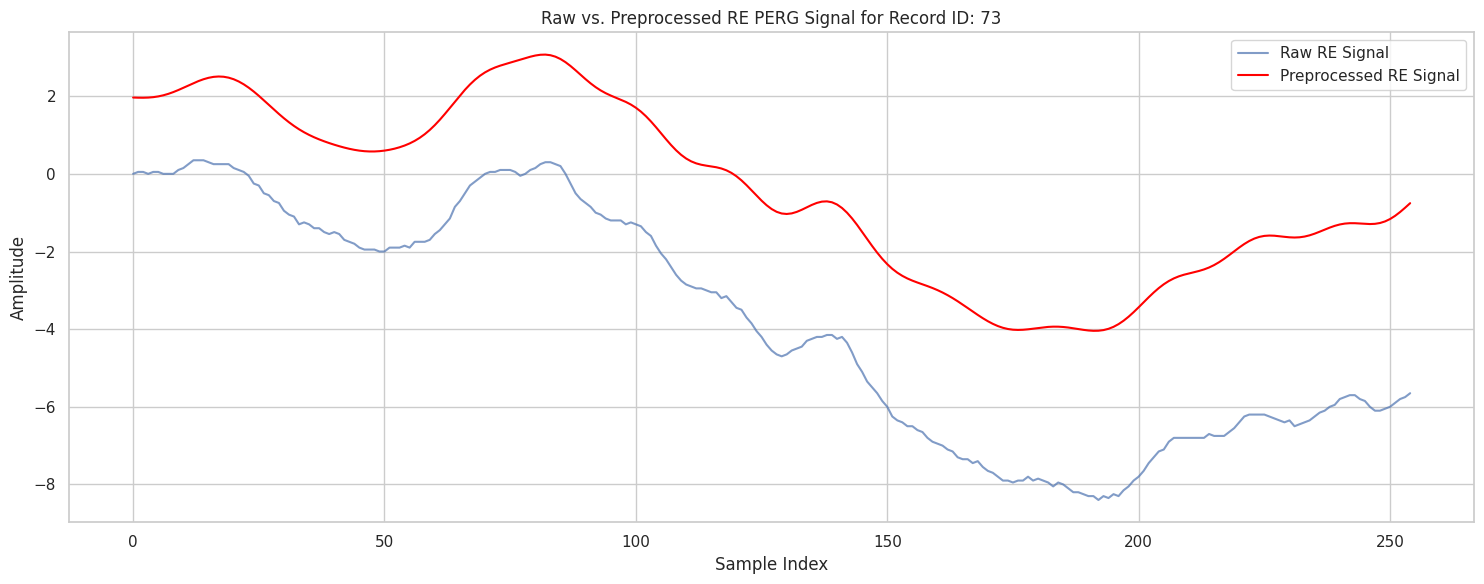

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Assuming meta dataframe and CSV_BASE path are available from Snippet 1
# Let's pick a random record for visualization
sample_rid = meta['id_record'].sample(random_state=RANDOM_STATE).iloc[0]

sample_path = os.path.join(CSV_BASE, f"{sample_rid:04d}.csv")

if os.path.exists(sample_path):
    sigdf_sample = pd.read_csv(sample_path)

    # Get raw RE signal
    re_cols_sample = [c for c in sigdf_sample.columns if c.startswith("RE_") and sigdf_sample[c].notna().any()]
    if re_cols_sample:
        raw_re_sig = sigdf_sample[re_cols_sample].mean(axis=1).values

        # Preprocess the raw signal using the function from Snippet 1
        fs = 1700 # Assuming fs=1700 as defined in Snippet 1
        preprocessed_re_sig = preprocess_signal(raw_re_sig, fs=fs)

        plt.figure(figsize=(15, 6))
        plt.plot(raw_re_sig, label='Raw RE Signal', alpha=0.7)
        if preprocessed_re_sig.size > 0:
            plt.plot(preprocessed_re_sig, label='Preprocessed RE Signal', color='red')
        plt.title(f'Raw vs. Preprocessed RE PERG Signal for Record ID: {sample_rid}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No RE signals found for record {sample_rid}")
else:
    print(f"Sample file not found for record {sample_rid}")

### 3. Class Distribution Plots

Visualizing the class distribution at different stages helps confirm the effect of SMOTE and understand the imbalance in the test set.

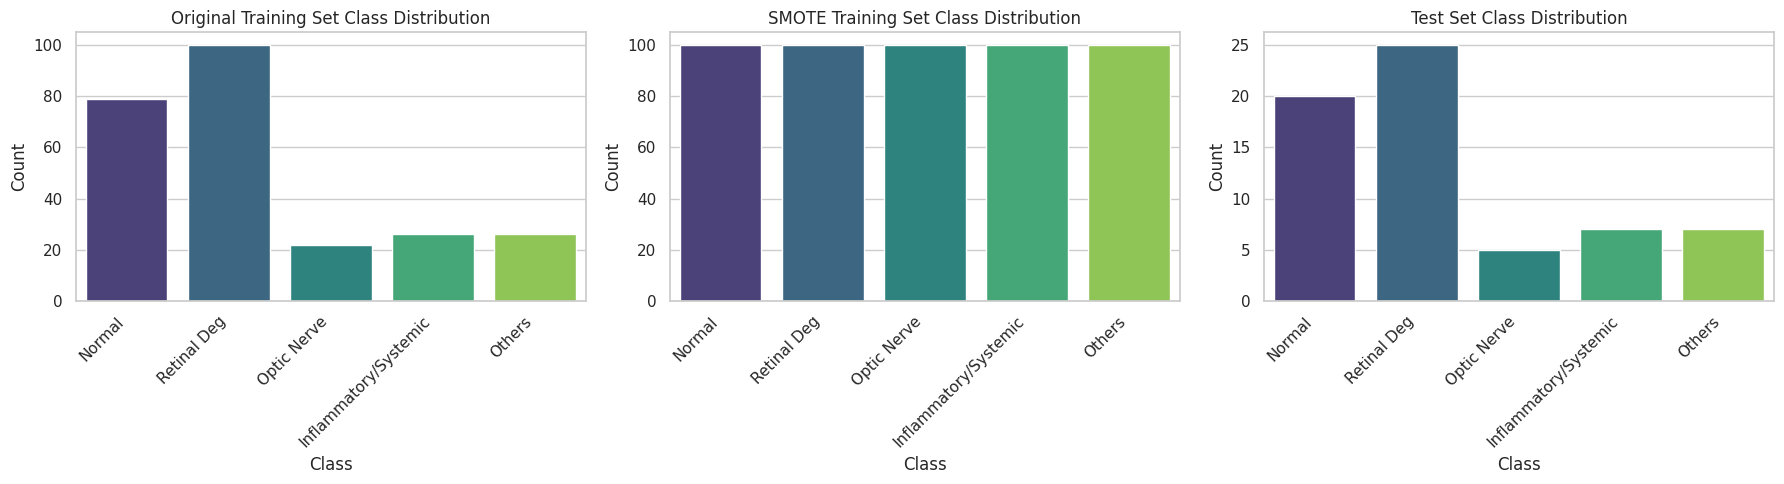

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original Training Distribution (before SMOTE)
sns.countplot(x=y_train, ax=axes[0], palette='viridis')
axes[0].set_title('Original Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(CLASS_NAMES_5, rotation=45, ha='right')

# Training Distribution After SMOTE
sns.countplot(x=y_train_res, ax=axes[1], palette='viridis')
axes[1].set_title('SMOTE Training Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(CLASS_NAMES_5, rotation=45, ha='right')

# Test Set Distribution
sns.countplot(x=y_test, ax=axes[2], palette='viridis')
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')
axes[2].set_xticklabels(CLASS_NAMES_5, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import pandas as pd

# Compute relevance (Mutual Information)
mi = mutual_info_classif(
    X_train_scaled,
    y_train_res,
    discrete_features=False,
    random_state=RANDOM_STATE
)

mi_scores = pd.Series(mi, index=X_cols_final).sort_values(ascending=False)

# Keep top-K relevant features (paper also reduces aggressively)
TOP_K = 40
top_relevant_features = mi_scores.head(TOP_K).index.tolist()

print("Top relevant features (MI):", len(top_relevant_features))


Top relevant features (MI): 40


In [ ]:
# Correlation matrix on selected features
X_relevant = pd.DataFrame(
    X_train_scaled,
    columns=X_cols_final
)[top_relevant_features]

corr_matrix = X_relevant.corr().abs()

selected_features = []
CORR_THRESHOLD = 0.85   # paper drops highly correlated features

for col in corr_matrix.columns:
    if all(corr_matrix[col][selected_features] < CORR_THRESHOLD) if selected_features else True:
        selected_features.append(col)

print("After MRMR (final selected features):", len(selected_features))


After MRMR (final selected features): 21


In [ ]:
# Final datasets after MRMR
X_train_final = pd.DataFrame(
    X_train_scaled,
    columns=X_cols_final
)[selected_features].values

X_test_final = pd.DataFrame(
    X_test_scaled,
    columns=X_cols_final
)[selected_features].values

FINAL_FEATURE_NAMES = selected_features

In [ ]:
print("Total features before MRMR:", X_train_scaled.shape[1])
print("Total features after MRMR :", X_train_final.shape[1])

Total features before MRMR: 106
Total features after MRMR : 21


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

n_estimators_range = list(range(50, 1000, 50))
results = []

best_f1 = -1
best_n = None
best_model = None

# =========================
# TRAIN LOOP
# =========================
for n in n_estimators_range:
    print(f"Training RF with n_estimators = {n}")

    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    )

    rf.fit(X_train_final, y_train_res)
    y_pred = rf.predict(X_test_final)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')

    results.append({
        "n_estimators": n,
        "accuracy": acc,
        "f1_weighted": f1w
    })

    # Track best model
    if f1w > best_f1:
        best_f1 = f1w
        best_n = n
        best_model = rf

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\nBEST MODEL")
print("Best n_estimators:", best_n)
print("Best weighted F1:", best_f1)


Training RF with n_estimators = 50
Training RF with n_estimators = 100
Training RF with n_estimators = 150
Training RF with n_estimators = 200
Training RF with n_estimators = 250
Training RF with n_estimators = 300
Training RF with n_estimators = 350
Training RF with n_estimators = 400
Training RF with n_estimators = 450
Training RF with n_estimators = 500
Training RF with n_estimators = 550
Training RF with n_estimators = 600
Training RF with n_estimators = 650
Training RF with n_estimators = 700
Training RF with n_estimators = 750
Training RF with n_estimators = 800
Training RF with n_estimators = 850
Training RF with n_estimators = 900
Training RF with n_estimators = 950
Training RF with n_estimators = 1000
Training RF with n_estimators = 1050
Training RF with n_estimators = 1100
Training RF with n_estimators = 1150
Training RF with n_estimators = 1200
Training RF with n_estimators = 1250
Training RF with n_estimators = 1300
Training RF with n_estimators = 1350
Training RF with n_es

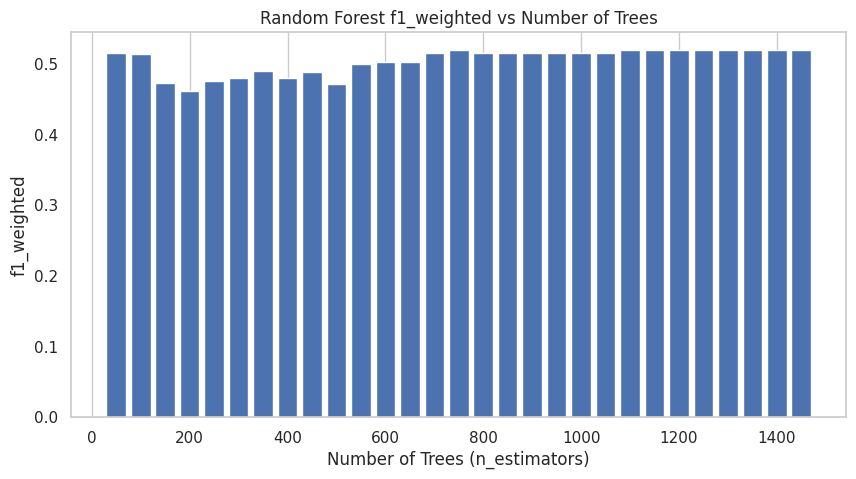

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(results_df["n_estimators"], results_df["f1_weighted"], width=40)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("f1_weighted")
plt.title("Random Forest f1_weighted vs Number of Trees")
plt.grid(axis="y")
plt.show()


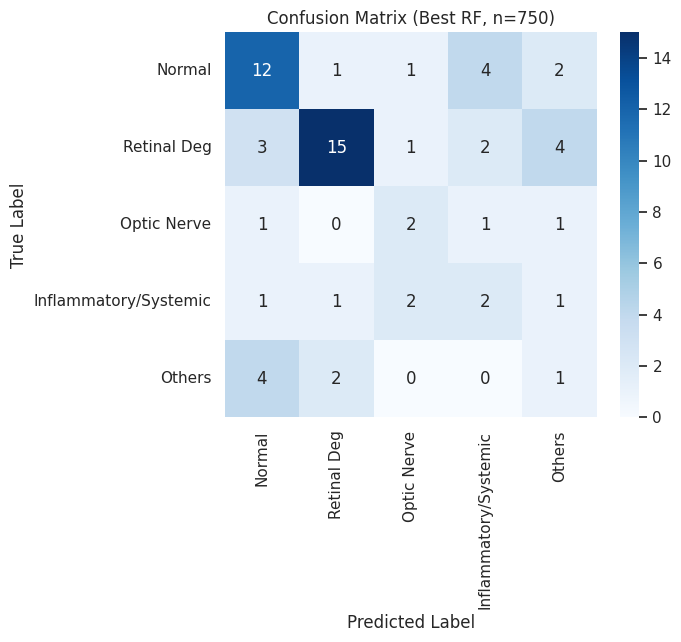


Classification Report (Best RF):
                       precision    recall  f1-score   support

               Normal       0.57      0.60      0.59        20
          Retinal Deg       0.79      0.60      0.68        25
          Optic Nerve       0.33      0.40      0.36         5
Inflammatory/Systemic       0.22      0.29      0.25         7
               Others       0.11      0.14      0.12         7

             accuracy                           0.50        64
            macro avg       0.41      0.41      0.40        64
         weighted avg       0.55      0.50      0.52        64



In [ ]:
# Predict using BEST model
y_best_pred = best_model.predict(X_test_final)

cm = confusion_matrix(y_test, y_best_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES_5,
    yticklabels=CLASS_NAMES_5
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Best RF, n={best_n})")
plt.show()

print("\nClassification Report (Best RF):")
print(classification_report(y_test, y_best_pred, target_names=CLASS_NAMES_5))


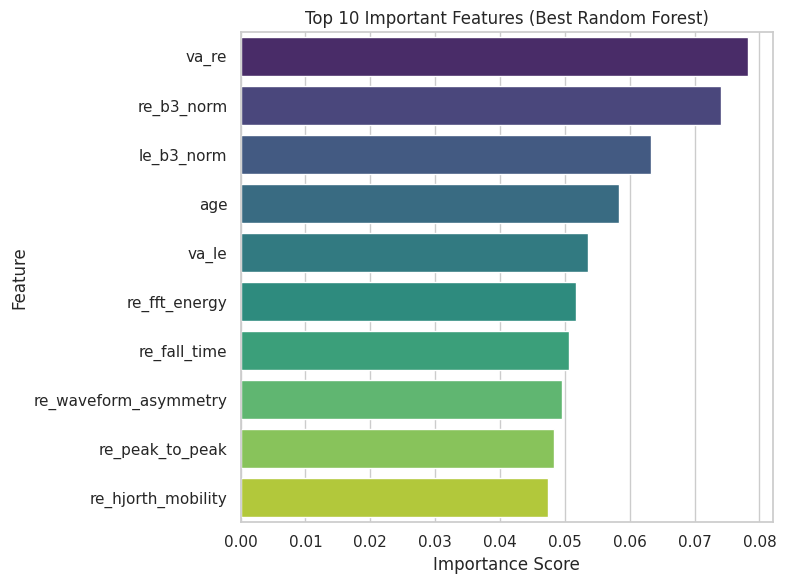

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(10),
    y=importances.head(10).index,
    palette="viridis"
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Best Random Forest)")
plt.tight_layout()
plt.show()

In [ ]:
if not XGB_AVAILABLE:
    print("XGBoost not available.")
else:
    import xgboost as xgb
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    n_estimators_range = list(range(50, 501, 50))
    results = []

    best_f1 = -1
    best_n = None
    best_model = None

    # =========================
    # TRAIN LOOP
    # =========================
    for n in n_estimators_range:
        print(f"Training XGBoost with n_estimators = {n}")

        model = xgb.XGBClassifier(
            n_estimators=n,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="multi:softmax",
            num_class=len(CLASS_NAMES_5),
            eval_metric="mlogloss",
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

        model.fit(X_train_final, y_train_res)
        y_pred = model.predict(X_test_final)

        acc = accuracy_score(y_test, y_pred)
        f1w = f1_score(y_test, y_pred, average="weighted")

        results.append({
            "n_estimators": n,
            "accuracy": acc,
            "f1_weighted": f1w
        })

        # Track best model
        if f1w > best_f1:
            best_f1 = f1w
            best_n = n
            best_model = model

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    print("\nBEST XGBOOST MODEL")
    print("Best n_estimators:", best_n)
    print("Best weighted F1:", best_f1)


Training XGBoost with n_estimators = 50
Training XGBoost with n_estimators = 100
Training XGBoost with n_estimators = 150
Training XGBoost with n_estimators = 200
Training XGBoost with n_estimators = 250
Training XGBoost with n_estimators = 300
Training XGBoost with n_estimators = 350
Training XGBoost with n_estimators = 400
Training XGBoost with n_estimators = 450
Training XGBoost with n_estimators = 500

BEST XGBOOST MODEL
Best n_estimators: 100
Best weighted F1: 0.47818287694172257


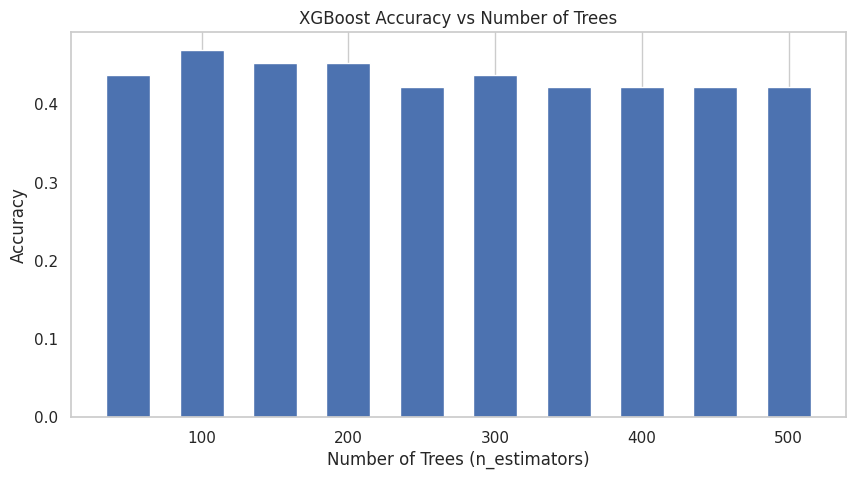

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(results_df["n_estimators"], results_df["accuracy"], width=30)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("XGBoost Accuracy vs Number of Trees")
plt.grid(axis="y")
plt.show()


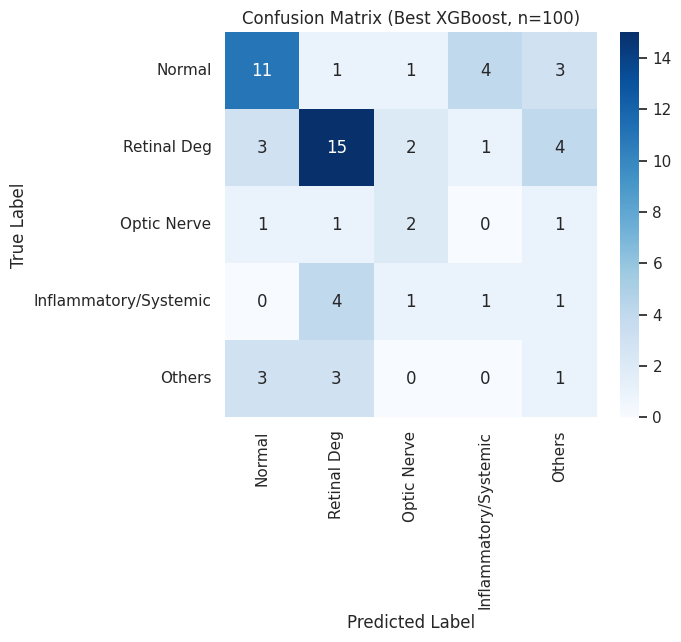


Classification Report (Best XGBoost):
                       precision    recall  f1-score   support

               Normal       0.61      0.55      0.58        20
          Retinal Deg       0.62      0.60      0.61        25
          Optic Nerve       0.33      0.40      0.36         5
Inflammatory/Systemic       0.17      0.14      0.15         7
               Others       0.10      0.14      0.12         7

             accuracy                           0.47        64
            macro avg       0.37      0.37      0.37        64
         weighted avg       0.49      0.47      0.48        64



In [ ]:
y_best_pred = best_model.predict(X_test_final)

cm = confusion_matrix(y_test, y_best_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES_5,
    yticklabels=CLASS_NAMES_5
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Best XGBoost, n={best_n})")
plt.show()

print("\nClassification Report (Best XGBoost):")
print(classification_report(y_test, y_best_pred, target_names=CLASS_NAMES_5))


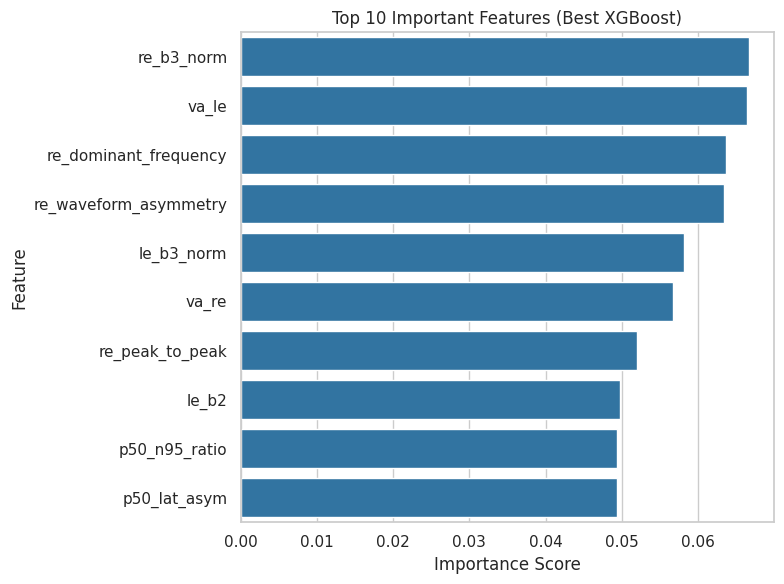

In [ ]:
importances = pd.Series(
    best_model.feature_importances_,
    index=FINAL_FEATURE_NAMES
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(10),
    y=importances.head(10).index,
    color="#1f77b4"
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Best XGBoost)")
plt.tight_layout()
plt.show()


In [ ]:
if not LGB_AVAILABLE:
    print("LightGBM not available; skipping LightGBM.")
else:
    import lightgbm as lgb
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

    num_leaves_list = [20, 40, 60, 80]
    n_estimators_range = list(range(10, 201, 10))

    results = []

    best_f1 = -1
    best_model = None
    best_params = None

    # =========================
    # TRAIN LOOP (DOUBLE LOOP)
    # =========================
    for nl in num_leaves_list:
        for n_est in n_estimators_range:
            print(f"Training LightGBM | num_leaves={nl}, n_estimators={n_est}")

            model = lgb.LGBMClassifier(
                num_leaves=nl,
                n_estimators=n_est,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                min_child_samples=20,
                random_state=RANDOM_STATE,
                n_jobs=-1
            )

            model.fit(X_train_final, y_train_res)
            y_pred = model.predict(X_test_final)

            acc = accuracy_score(y_test, y_pred)
            f1w = f1_score(y_test, y_pred, average="weighted")

            results.append({
                "num_leaves": nl,
                "n_estimators": n_est,
                "accuracy": acc,
                "f1_weighted": f1w
            })

            # Track best model
            if f1w > best_f1:
                best_f1 = f1w
                best_model = model
                best_params = {
                    "num_leaves": nl,
                    "n_estimators": n_est
                }

    results_df = pd.DataFrame(results)

    print("\nBEST LIGHTGBM MODEL")
    print("Best parameters:", best_params)
    print("Best weighted F1:", best_f1)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

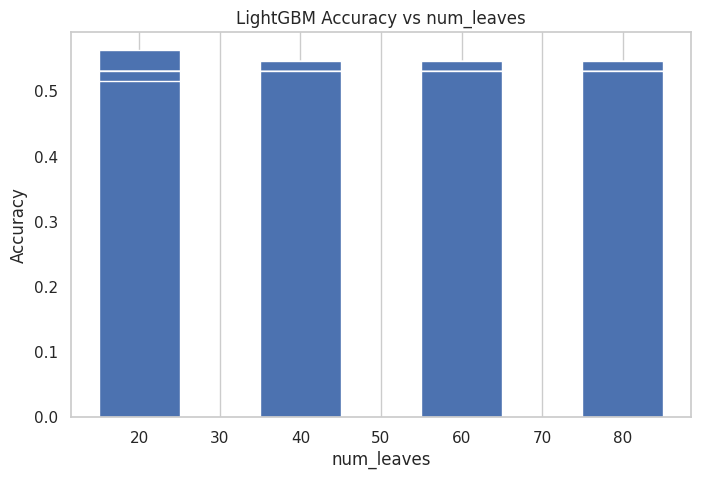

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df["num_leaves"], results_df["accuracy"], width=10)
plt.xlabel("num_leaves")
plt.ylabel("Accuracy")
plt.title("LightGBM Accuracy vs num_leaves")
plt.grid(axis="y")
plt.show()


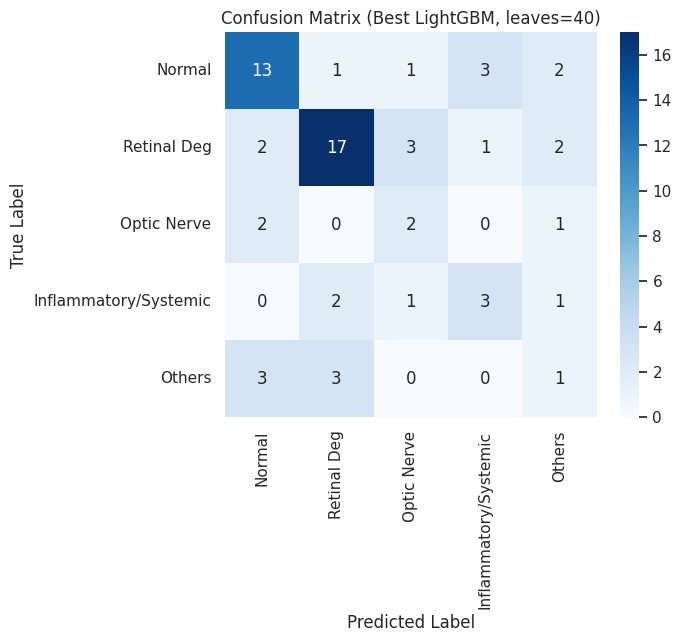


Classification Report (Best LightGBM):
                       precision    recall  f1-score   support

               Normal       0.65      0.65      0.65        20
          Retinal Deg       0.74      0.68      0.71        25
          Optic Nerve       0.29      0.40      0.33         5
Inflammatory/Systemic       0.43      0.43      0.43         7
               Others       0.14      0.14      0.14         7

             accuracy                           0.56        64
            macro avg       0.45      0.46      0.45        64
         weighted avg       0.58      0.56      0.57        64



In [ ]:
y_best_pred = best_model.predict(X_test_final)

cm = confusion_matrix(y_test, y_best_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES_5,
    yticklabels=CLASS_NAMES_5
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Best LightGBM, leaves={best_leaves})")
plt.show()

print("\nClassification Report (Best LightGBM):")
print(classification_report(y_test, y_best_pred, target_names=CLASS_NAMES_5))


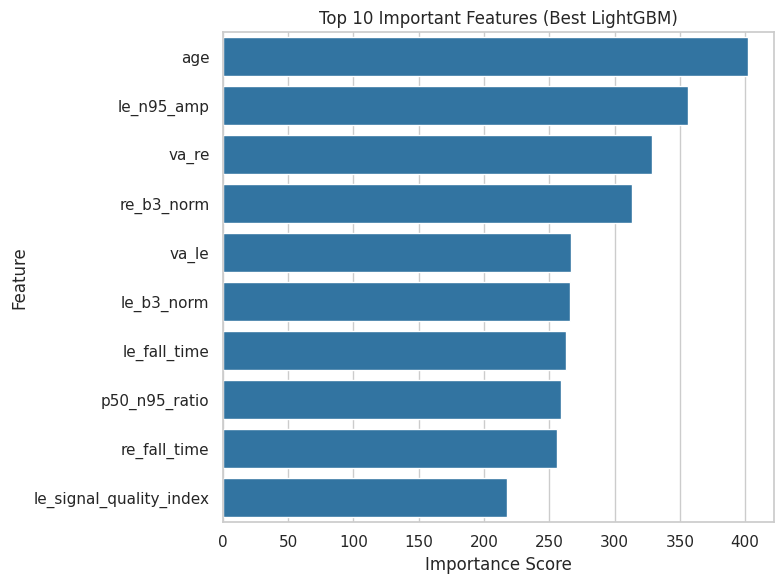

In [ ]:
importances = pd.Series(
    best_model.feature_importances_,
    index=FINAL_FEATURE_NAMES
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(10),
    y=importances.head(10).index,
    color="#1f77b4"
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Best LightGBM)")
plt.tight_layout()
plt.show()


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

cat_depths = [4, 6, 8, 10]
results = []

best_f1 = -1
best_depth = None
best_model = None

# =========================
# TRAIN LOOP
# =========================
for d in cat_depths:
    print(f"Training CatBoost with depth = {d}")

    model = CatBoostClassifier(
        depth=d,
        iterations=300,
        learning_rate=0.05,
        l2_leaf_reg=3,
        bagging_temperature=0.2,
        border_count=128,
        verbose=0,
        random_state=RANDOM_STATE
    )

    model.fit(X_train_final, y_train_res)
    y_pred = model.predict(X_test_final)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")

    results.append({
        "depth": d,
        "accuracy": acc,
        "f1_weighted": f1w
    })

    # Track best model
    if f1w > best_f1:
        best_f1 = f1w
        best_depth = d
        best_model = model

results_df = pd.DataFrame(results)

print("\nBEST CATBOOST MODEL")
print("Best depth:", best_depth)
print("Best weighted F1:", best_f1)


Training CatBoost with depth = 4
Training CatBoost with depth = 6
Training CatBoost with depth = 8
Training CatBoost with depth = 10

BEST CATBOOST MODEL
Best depth: 8
Best weighted F1: 0.540085914685023


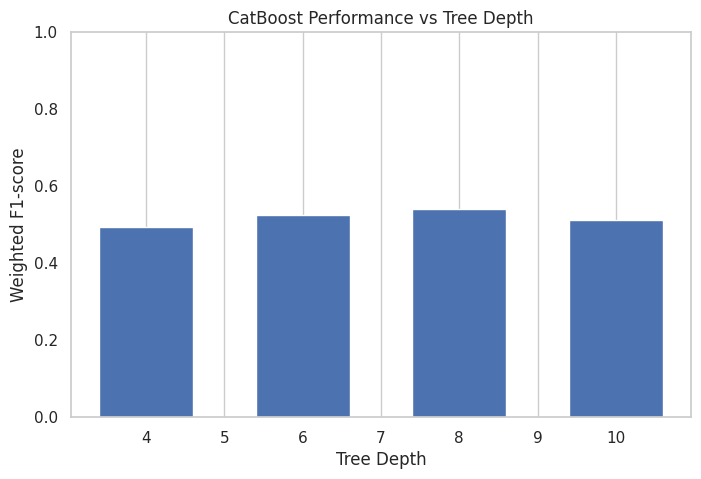

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df["depth"], results_df["f1_weighted"], width=1.2)
plt.xlabel("Tree Depth")
plt.ylabel("Weighted F1-score")
plt.title("CatBoost Performance vs Tree Depth")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()


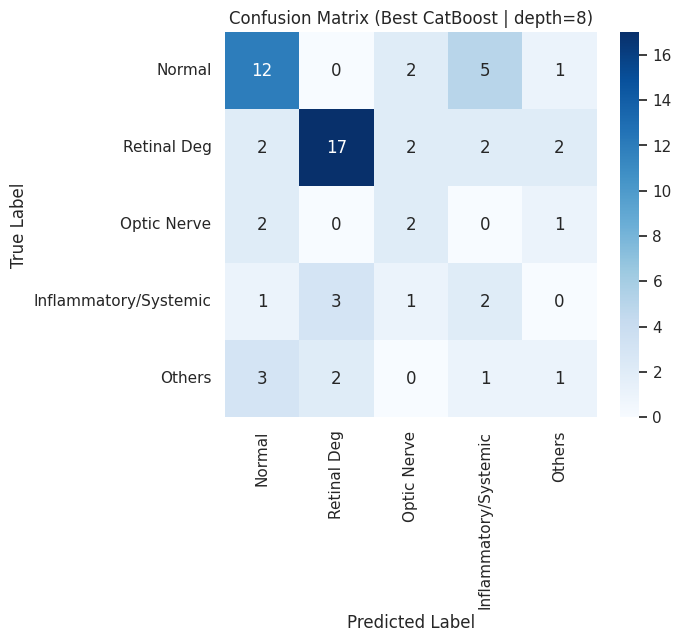


Classification Report (Best CatBoost):
                       precision    recall  f1-score   support

               Normal       0.60      0.60      0.60        20
          Retinal Deg       0.77      0.68      0.72        25
          Optic Nerve       0.29      0.40      0.33         5
Inflammatory/Systemic       0.20      0.29      0.24         7
               Others       0.20      0.14      0.17         7

             accuracy                           0.53        64
            macro avg       0.41      0.42      0.41        64
         weighted avg       0.56      0.53      0.54        64



In [ ]:
y_best_pred = best_model.predict(X_test_final)

cm = confusion_matrix(y_test, y_best_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES_5,
    yticklabels=CLASS_NAMES_5
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Best CatBoost | depth={best_depth})")
plt.show()

print("\nClassification Report (Best CatBoost):")
print(classification_report(y_test, y_best_pred, target_names=CLASS_NAMES_5))


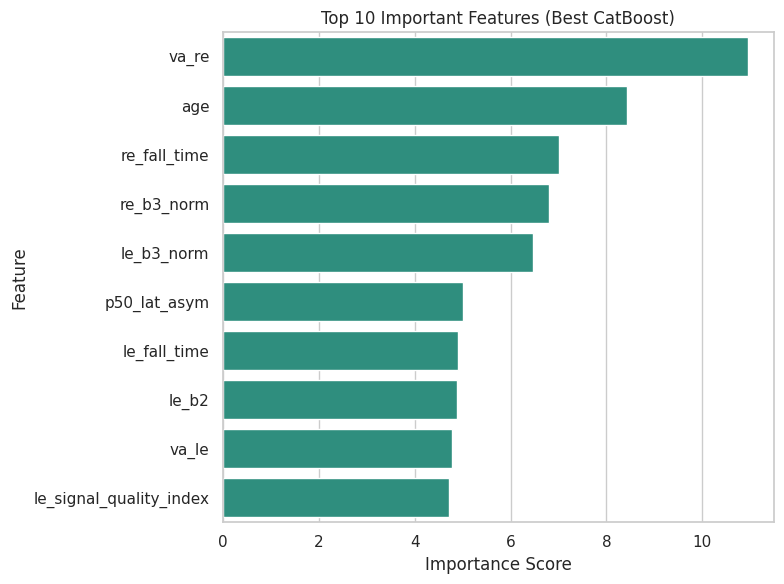

In [ ]:
importances = pd.Series(
    best_model.get_feature_importance(),
    index=FINAL_FEATURE_NAMES
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(10),
    y=importances.head(10).index,
      color="#1f9e89"
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Best CatBoost)")
plt.tight_layout()
plt.show()


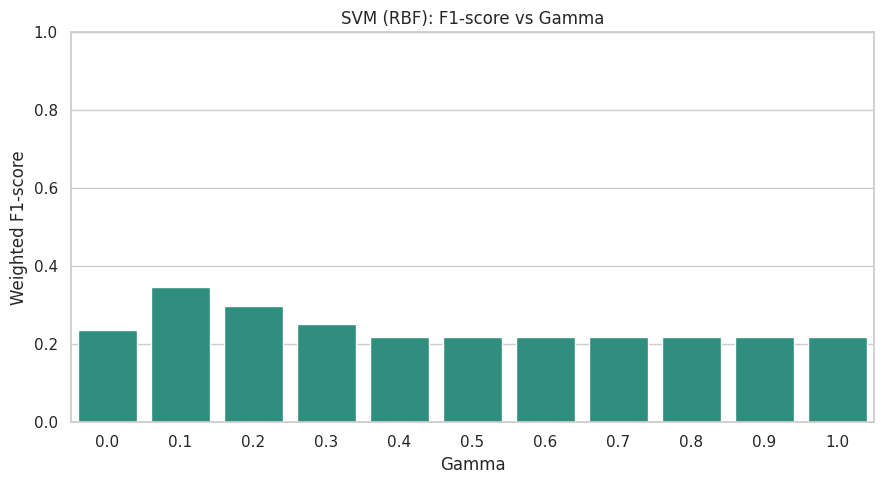

BEST SVM-RBF gamma: 0.1
BEST weighted F1: 0.34598214285714285

Classification Report (Best SVM-RBF):
                       precision    recall  f1-score   support

               Normal     0.6250    0.2500    0.3571        20
          Retinal Deg     0.4364    0.9600    0.6000        25
          Optic Nerve     0.0000    0.0000    0.0000         5
Inflammatory/Systemic     0.0000    0.0000    0.0000         7
               Others     0.0000    0.0000    0.0000         7

             accuracy                         0.4531        64
            macro avg     0.2123    0.2420    0.1914        64
         weighted avg     0.3658    0.4531    0.3460        64



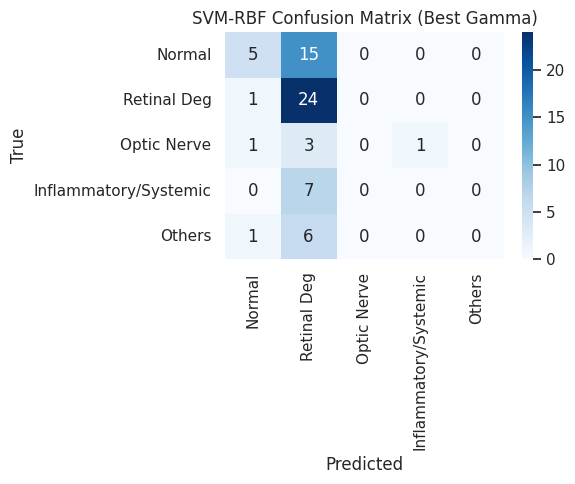

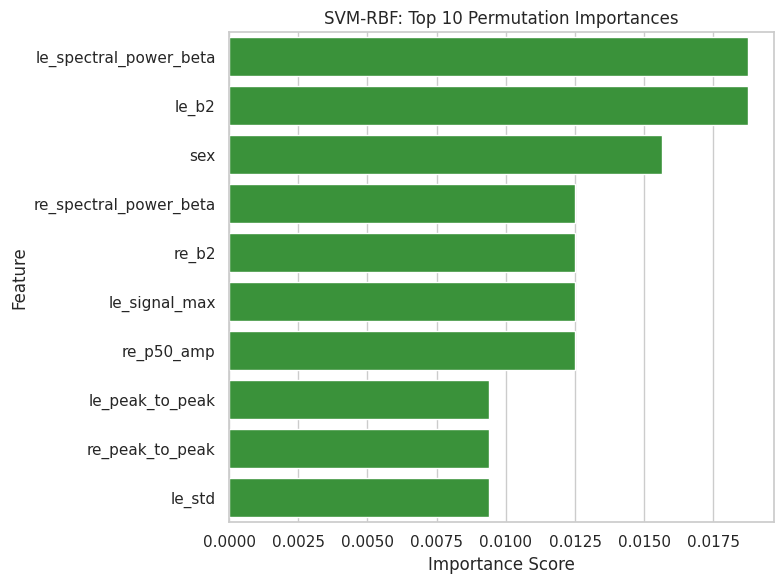

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
RANDOM_STATE = 42
svm_gamma_list = list(np.round(np.arange(0.0, 1.01, 0.1), 2))
results = []

best_f1 = -1
best_gamma = None
best_model = None

# =========================
# TRAIN LOOP
# =========================
for g in svm_gamma_list:
    gamma_eff = float(g) if g > 0 else 1e-6

    model = SVC(
        kernel='rbf',
        gamma=gamma_eff,
        C=3,
        probability=True,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )

    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')

    results.append({
        "gamma": g,
        "accuracy": acc,
        "f1_weighted": f1w
    })

    if f1w > best_f1:
        best_f1 = f1w
        best_gamma = g
        best_model = model

# =========================
# RESULTS BAR CHART
# =========================
df = pd.DataFrame(results)

plt.figure(figsize=(9,5))
sns.barplot(
    x=df["gamma"],
    y=df["f1_weighted"],
    color="#1f9e89"
)
plt.xlabel("Gamma")
plt.ylabel("Weighted F1-score")
plt.title("SVM (RBF): F1-score vs Gamma")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

print("BEST SVM-RBF gamma:", best_gamma)
print("BEST weighted F1:", best_f1)

# =========================
# BEST MODEL EVALUATION
# =========================
y_best = best_model.predict(X_test_scaled)

print("\nClassification Report (Best SVM-RBF):")
print(classification_report(y_test, y_best, target_names=CLASS_NAMES_5, digits=4))

cm = confusion_matrix(y_test, y_best)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d',
    cmap="Blues",
    xticklabels=CLASS_NAMES_5,
    yticklabels=CLASS_NAMES_5
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM-RBF Confusion Matrix (Best Gamma)")
plt.tight_layout()
plt.show()

# =========================
# PERMUTATION IMPORTANCE (BEST MODEL)
# =========================
perm = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

imp = pd.Series(
    perm.importances_mean,
    index=X_cols_final
).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(
    x=imp.values,
    y=imp.index,
    color="#2ca02c"
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("SVM-RBF: Top 10 Permutation Importances")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.svm import SVC


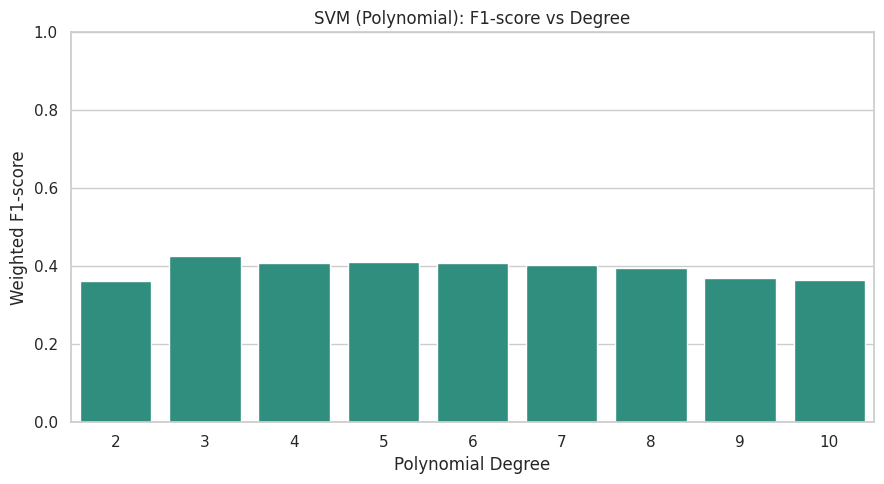

BEST SVM-Poly degree: 3
BEST weighted F1: 0.42570291327913273

Classification Report (Best SVM-Poly):
                       precision    recall  f1-score   support

               Normal     0.6364    0.7000    0.6667        20
          Retinal Deg     0.5000    0.3200    0.3902        25
          Optic Nerve     0.2857    0.4000    0.3333         5
Inflammatory/Systemic     0.1818    0.2857    0.2222         7
               Others     0.1250    0.1429    0.1333         7

             accuracy                         0.4219        64
            macro avg     0.3458    0.3697    0.3492        64
         weighted avg     0.4501    0.4219    0.4257        64



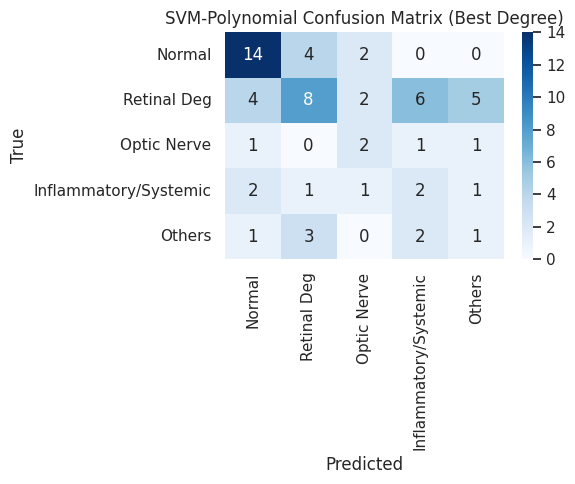

NameError: name 'permutation_importance' is not defined

In [ ]:
RANDOM_STATE = 42
svm_poly_degrees = list(range(2, 11))
results = []

best_f1 = -1
best_degree = None
best_model = None

# =========================
# TRAIN LOOP
# =========================
for d in svm_poly_degrees:
    model = SVC(
        kernel='poly',
        degree=d,
        C=3,
        gamma='scale',
        coef0=1,
        probability=True,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )

    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')

    results.append({
        "degree": d,
        "accuracy": acc,
        "f1_weighted": f1w
    })

    if f1w > best_f1:
        best_f1 = f1w
        best_degree = d
        best_model = model

# =========================
# BAR CHART
# =========================
df = pd.DataFrame(results)

plt.figure(figsize=(9,5))
sns.barplot(
    x=df["degree"],
    y=df["f1_weighted"],
    color="#1f9e89"
)
plt.xlabel("Polynomial Degree")
plt.ylabel("Weighted F1-score")
plt.title("SVM (Polynomial): F1-score vs Degree")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

print("BEST SVM-Poly degree:", best_degree)
print("BEST weighted F1:", best_f1)

# =========================
# BEST MODEL EVALUATION
# =========================
y_best = best_model.predict(X_test_scaled)

print("\nClassification Report (Best SVM-Poly):")
print(classification_report(y_test, y_best, target_names=CLASS_NAMES_5, digits=4))

cm = confusion_matrix(y_test, y_best)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d',
    cmap="Blues",
    xticklabels=CLASS_NAMES_5,
    yticklabels=CLASS_NAMES_5
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM-Polynomial Confusion Matrix (Best Degree)")
plt.tight_layout()
plt.show()

# =========================
# PERMUTATION IMPORTANCE
# =========================
perm = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

imp = pd.Series(
    perm.importances_mean,
    index=X_cols_final
).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(
    x=imp.values,
    y=imp.index,
    color="#2ca02c"
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("SVM-Polynomial: Top 15 Permutation Importances")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import time
import numpy as np

_n_samples = X_train_res.shape[0]
max_k = max(2, int(np.floor(np.sqrt(_n_samples))))
knn_ks = list(range(2, max_k+1, 2))

results = []
best_f1 = -1
best_k = None
best_model = None

for k in knn_ks:
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")

    results.append({"k": k, "accuracy": acc, "f1": f1w})

    if f1w > best_f1:
        best_f1 = f1w
        best_k = k
        best_model = model

results_df = pd.DataFrame(results)

print("BEST KNN")
print("k =", best_k)
print("Weighted F1 =", best_f1)


BEST KNN
k = 10
Weighted F1 = 0.3421176781400966


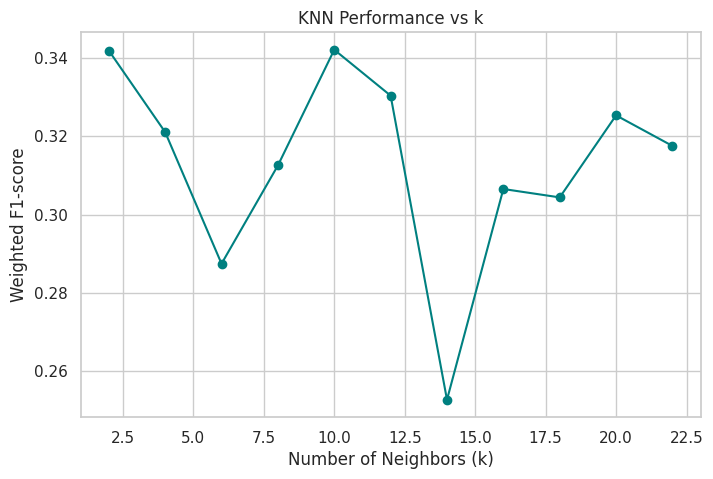

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(results_df["k"], results_df["f1"], marker="o", color="teal")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Weighted F1-score")
plt.title("KNN Performance vs k")
plt.grid(True)
plt.show()



Classification Report (Best KNN):
                       precision    recall  f1-score   support

               Normal       0.62      0.50      0.56        20
          Retinal Deg       0.55      0.24      0.33        25
          Optic Nerve       0.09      0.20      0.12         5
Inflammatory/Systemic       0.19      0.43      0.26         7
               Others       0.00      0.00      0.00         7

             accuracy                           0.31        64
            macro avg       0.29      0.27      0.25        64
         weighted avg       0.44      0.31      0.34        64



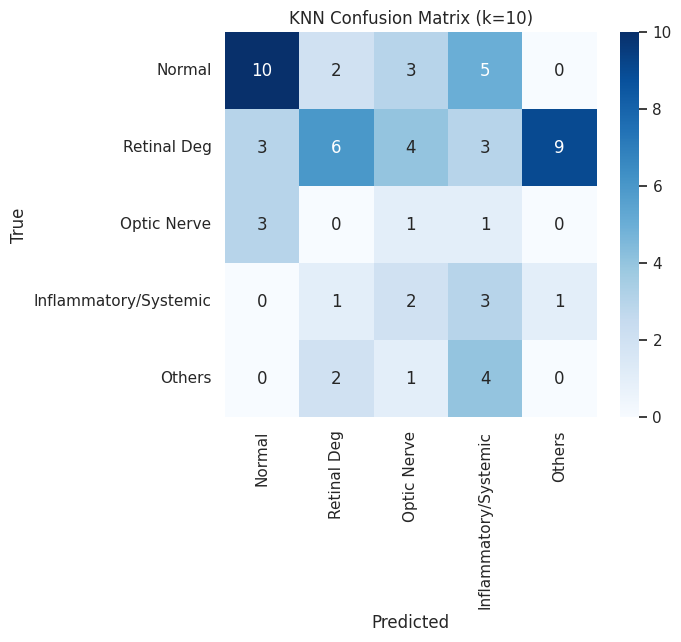

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_best = best_model.predict(X_test_scaled)

print("\nClassification Report (Best KNN):")
print(classification_report(y_test, y_best, target_names=CLASS_NAMES_5))

cm = confusion_matrix(y_test, y_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES_5,
            yticklabels=CLASS_NAMES_5,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"KNN Confusion Matrix (k={best_k})")
plt.show()


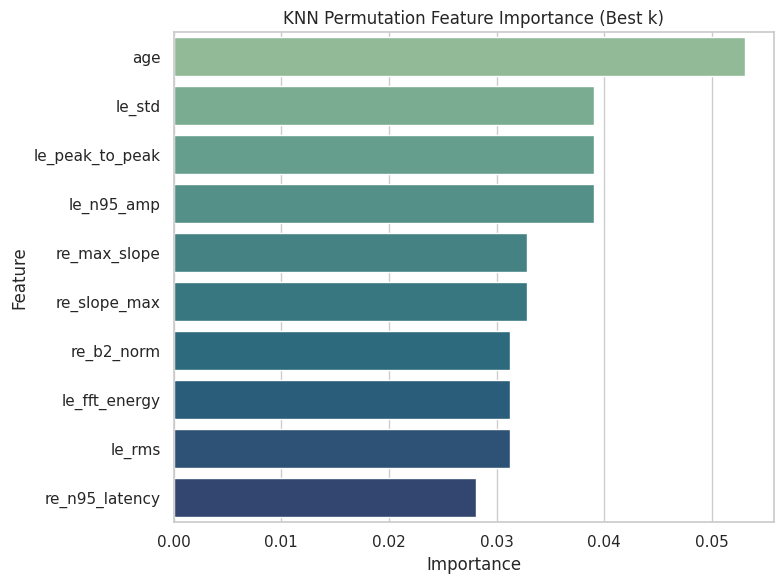

In [ ]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

imp = pd.Series(perm.importances_mean, index=X_cols_final)\
        .sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=imp.values, y=imp.index, palette="crest")
plt.title("KNN Permutation Feature Importance (Best k)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import time

logreg_C = [0.01, 0.1, 1, 10, 100]

results = []
best_f1 = -1
best_C = None
best_model = None

for Cval in logreg_C:
    model = LogisticRegression(
        C=float(Cval),
        penalty="l2",
        solver="saga",
        multi_class="multinomial",
        max_iter=3000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )

    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")

    results.append({"C": Cval, "accuracy": acc, "f1": f1w})

    if f1w > best_f1:
        best_f1 = f1w
        best_C = Cval
        best_model = model

results_df = pd.DataFrame(results)

print("BEST Logistic Regression")
print("C =", best_C)
print("Weighted F1 =", best_f1)


BEST Logistic Regression
C = 0.1
Weighted F1 = 0.43126953887160674


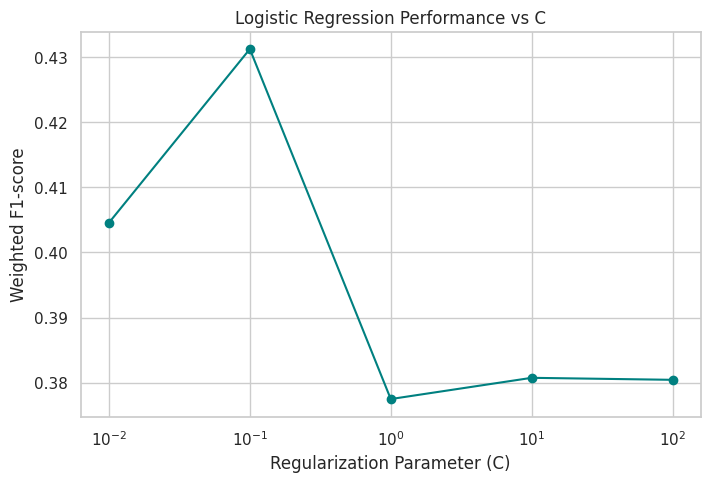

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(results_df["C"], results_df["f1"], marker="o", color="teal")
plt.xscale("log")
plt.xlabel("Regularization Parameter (C)")
plt.ylabel("Weighted F1-score")
plt.title("Logistic Regression Performance vs C")
plt.grid(True)
plt.show()



Classification Report (Best Logistic Regression):
                       precision    recall  f1-score   support

               Normal       0.59      0.50      0.54        20
          Retinal Deg       0.62      0.40      0.49        25
          Optic Nerve       0.12      0.20      0.15         5
Inflammatory/Systemic       0.19      0.43      0.26         7
               Others       0.29      0.29      0.29         7

             accuracy                           0.41        64
            macro avg       0.36      0.36      0.35        64
         weighted avg       0.49      0.41      0.43        64



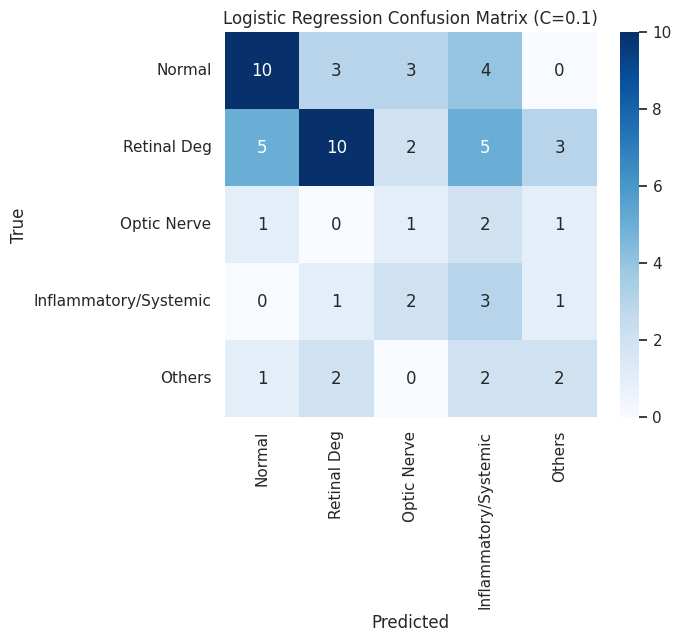

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_best = best_model.predict(X_test_scaled)

print("\nClassification Report (Best Logistic Regression):")
print(classification_report(y_test, y_best, target_names=CLASS_NAMES_5))

cm = confusion_matrix(y_test, y_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES_5,
            yticklabels=CLASS_NAMES_5,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Logistic Regression Confusion Matrix (C={best_C})")
plt.show()


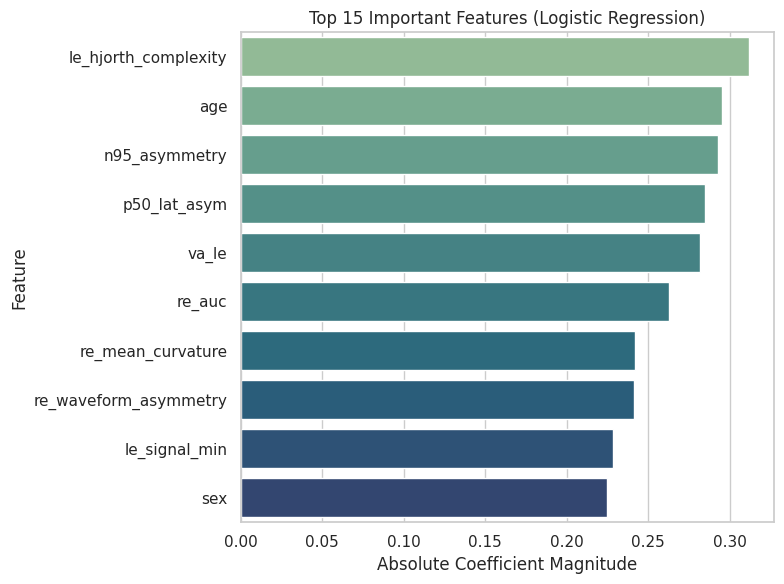

In [ ]:
coef = best_model.coef_
importance = pd.Series(
    np.mean(np.abs(coef), axis=0),
    index=X_cols_final
).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=importance.values, y=importance.index, palette="crest")
plt.xlabel("Absolute Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Top 15 Important Features (Logistic Regression)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import time

ann_hidden = [(50,100), (100,200), (150,300)]

results = []
best_f1 = -1
best_h = None
best_model = None

for hl in ann_hidden:
    model = MLPClassifier(
        hidden_layer_sizes=hl,
        max_iter=1500,
        alpha=0.0001,
        learning_rate_init=0.001,
        early_stopping=True,
        random_state=RANDOM_STATE
    )

    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")

    results.append({
        "hidden_layers": str(hl),
        "accuracy": acc,
        "f1": f1w
    })

    if f1w > best_f1:
        best_f1 = f1w
        best_h = hl
        best_model = model

results_df = pd.DataFrame(results)

print("BEST ANN architecture:", best_h)
print("BEST Weighted F1:", best_f1)


BEST ANN architecture: (100, 200)
BEST Weighted F1: 0.48858316460103945


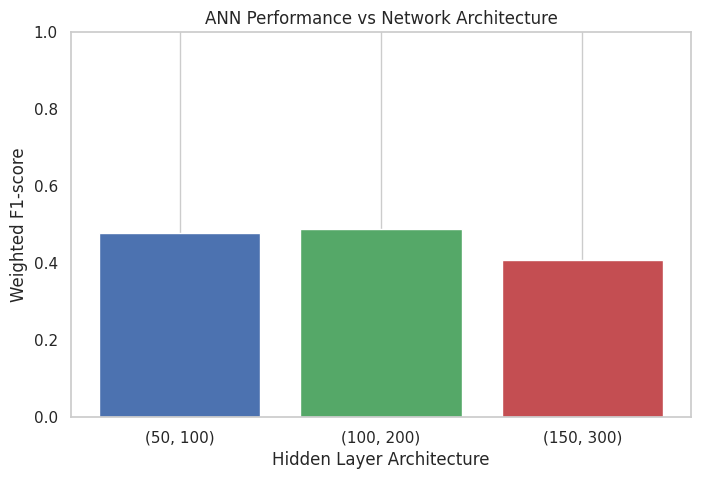

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df["hidden_layers"], results_df["f1"],
        color=["#4C72B0", "#55A868", "#C44E52"])
plt.xlabel("Hidden Layer Architecture")
plt.ylabel("Weighted F1-score")
plt.title("ANN Performance vs Network Architecture")
plt.ylim(0,1)
plt.grid(axis="y")
plt.show()



Classification Report (Best ANN):
                       precision    recall  f1-score   support

               Normal       0.67      0.50      0.57        20
          Retinal Deg       0.57      0.64      0.60        25
          Optic Nerve       0.40      0.40      0.40         5
Inflammatory/Systemic       0.17      0.29      0.21         7
               Others       0.25      0.14      0.18         7

             accuracy                           0.48        64
            macro avg       0.41      0.39      0.39        64
         weighted avg       0.51      0.48      0.49        64



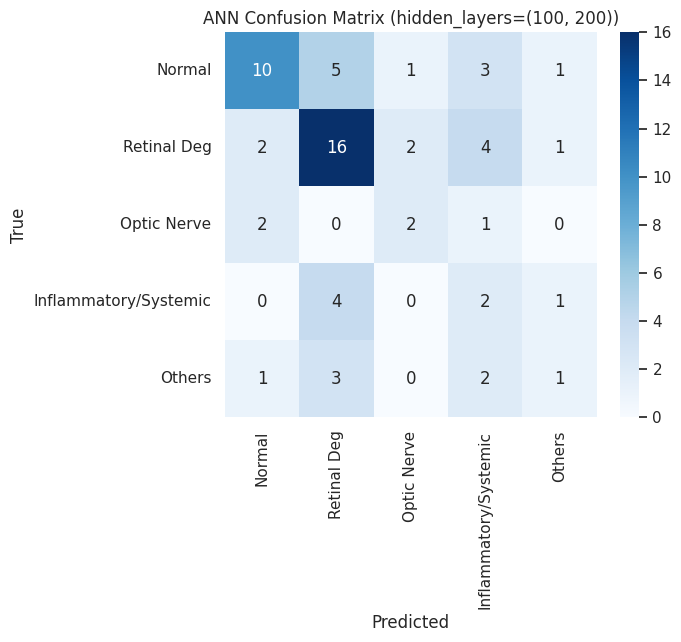

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_best = best_model.predict(X_test_scaled)

print("\nClassification Report (Best ANN):")
print(classification_report(y_test, y_best, target_names=CLASS_NAMES_5))

cm = confusion_matrix(y_test, y_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES_5,
            yticklabels=CLASS_NAMES_5,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"ANN Confusion Matrix (hidden_layers={best_h})")
plt.show()


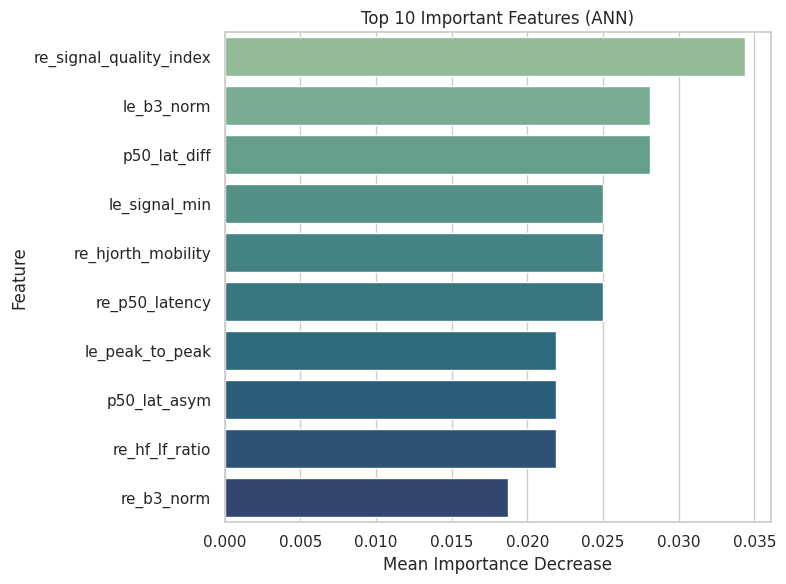

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

imp = pd.Series(
    r.importances_mean,
    index=X_cols_final
).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=imp.values, y=imp.index, palette="crest")
plt.xlabel("Mean Importance Decrease")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (ANN)")
plt.tight_layout()
plt.show()


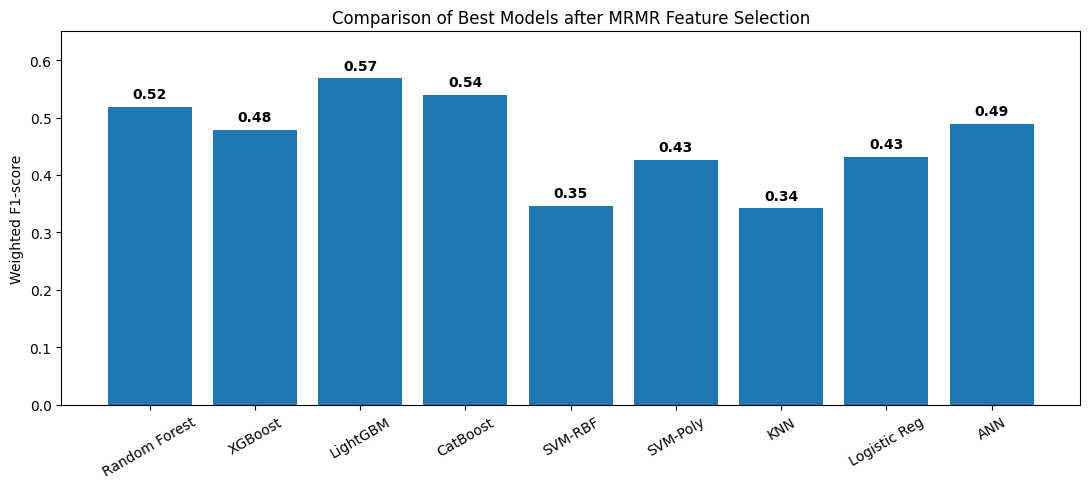

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    "Random Forest",
    "XGBoost",
    "LightGBM",
    "CatBoost",
    "SVM-RBF",
    "SVM-Poly",
    "KNN",
    "Logistic Reg",
    "ANN"
]

best_f1 = [
    0.519,
    0.478,
    0.568,
    0.540,
    0.346,
    0.426,
    0.342,
    0.431,
    0.489
]

x = np.arange(len(models))

plt.figure(figsize=(11,5))

bars = plt.bar(
    x,
    best_f1,
    color="#1f77b4"   # solid bars, no borders
)

# 🔹 value on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.xticks(x, models, rotation=30)
plt.ylabel("Weighted F1-score")
plt.title("Comparison of Best Models after MRMR Feature Selection")
plt.ylim(0, 0.65)

# 🔹 only horizontal grid (optional, looks good in papers)
plt.grid(axis='y', linestyle='', alpha=0.5)

plt.tight_layout()
plt.show()


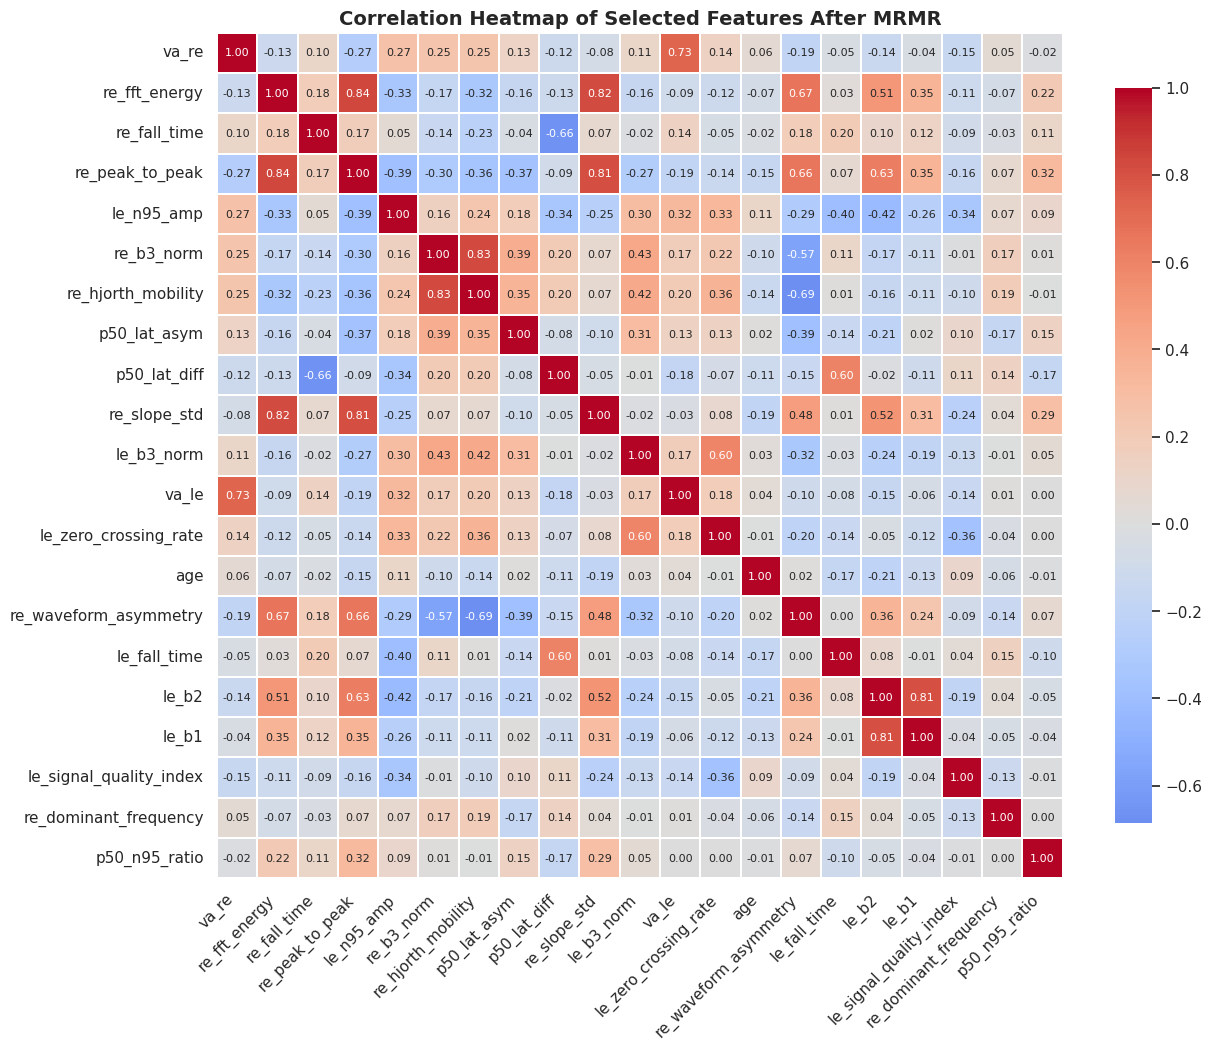

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrame from MRMR-selected features
df_mrmr = pd.DataFrame(
    X_train_final,
    columns=FINAL_FEATURE_NAMES
)

# Correlation matrix
corr_mrmr = df_mrmr.corr()

# Plot heatmap WITH VALUES
plt.figure(figsize=(13, 11))
sns.heatmap(
    corr_mrmr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.3,
    annot=True,                # ✅ show values
    fmt=".2f",                 # ✅ 2 decimal precision
    annot_kws={"size": 8},     # ✅ readable text size
    cbar_kws={"shrink": 0.8}
)

plt.title(
    "Correlation Heatmap of Selected Features After MRMR",
    fontsize=14,
    fontweight="bold"
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


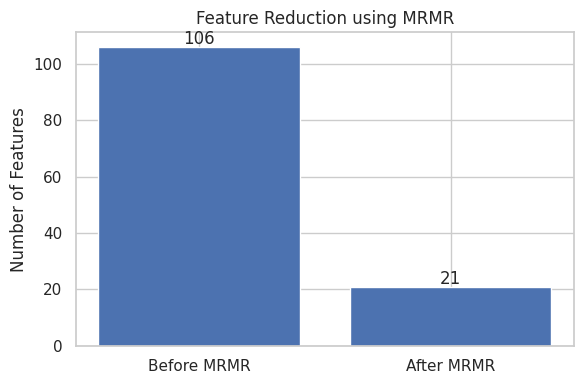

In [ ]:
import matplotlib.pyplot as plt

stages = ["Before MRMR", "After MRMR"]
feature_counts = [106, len(FINAL_FEATURE_NAMES)]

plt.figure(figsize=(6,4))
bars = plt.bar(stages, feature_counts)

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        str(int(bar.get_height())),
        ha='center'
    )

plt.ylabel("Number of Features")
plt.title("Feature Reduction using MRMR")
plt.tight_layout()
plt.show()
